## This dataset comes from Kaggle - https://www.kaggle.com/dalpozz/creditcardfraud
## This tutorial demonstrates how to use unsupervised training for fraud detection. The main model implemented here is auto-encoder, which achives 0.95 of AUC on test set. 
### Author: Weimin Wang
### Date: June 18, 2017

## Load libraries 

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from datetime import datetime 
from sklearn.metrics import roc_auc_score as auc 
import seaborn as sns

In [4]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

## Data Exploration

In [5]:
df = pd.read_csv('../data/creditcard.csv')

In [6]:
df.shape

(284807, 31)

In [7]:
print("Total time spanning: {:.1f} days".format(df['Time'].max() / (3600 * 24.0)))
print("{:.3f} % of all transactions are fraud. ".format(np.sum(df['Class']) / df.shape[0] * 100))

Total time spanning: 2.0 days
0.173 % of all transactions are fraud. 


In [8]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [9]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [10]:
df.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

(array([  1.,   1.,   2.,   2.,   1.,   1.,   4.,   2.,   1.,   1.,   2.,
          1.,   2.,   1.,   2.,   1.,   2.,   2.,   2.,   4.,   3.,   4.,
          2.,   6.,   2.,   3.,  10.,   5.,   2.,   3.,   9.,   3.,   2.,
          5.,   4.,  10.,  10.,  14.,  18.,  19.,  22.,  22.,  25.,  43.,
         45.,  35.,  32.,  37.,  47.,  15.]),
 array([-30.55238004, -29.89868472, -29.2449894 , -28.59129408,
        -27.93759876, -27.28390344, -26.63020812, -25.97651279,
        -25.32281747, -24.66912215, -24.01542683, -23.36173151,
        -22.70803619, -22.05434087, -21.40064555, -20.74695022,
        -20.0932549 , -19.43955958, -18.78586426, -18.13216894,
        -17.47847362, -16.8247783 , -16.17108298, -15.51738765,
        -14.86369233, -14.20999701, -13.55630169, -12.90260637,
        -12.24891105, -11.59521573, -10.9415204 , -10.28782508,
         -9.63412976,  -8.98043444,  -8.32673912,  -7.6730438 ,
         -7.01934848,  -6.36565316,  -5.71195783,  -5.05826251,
         -4.404567

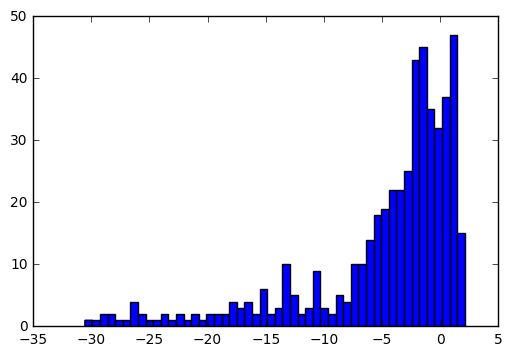

In [11]:
plt.hist(df.loc[df.Class == 1, 'V1'], bins=50)

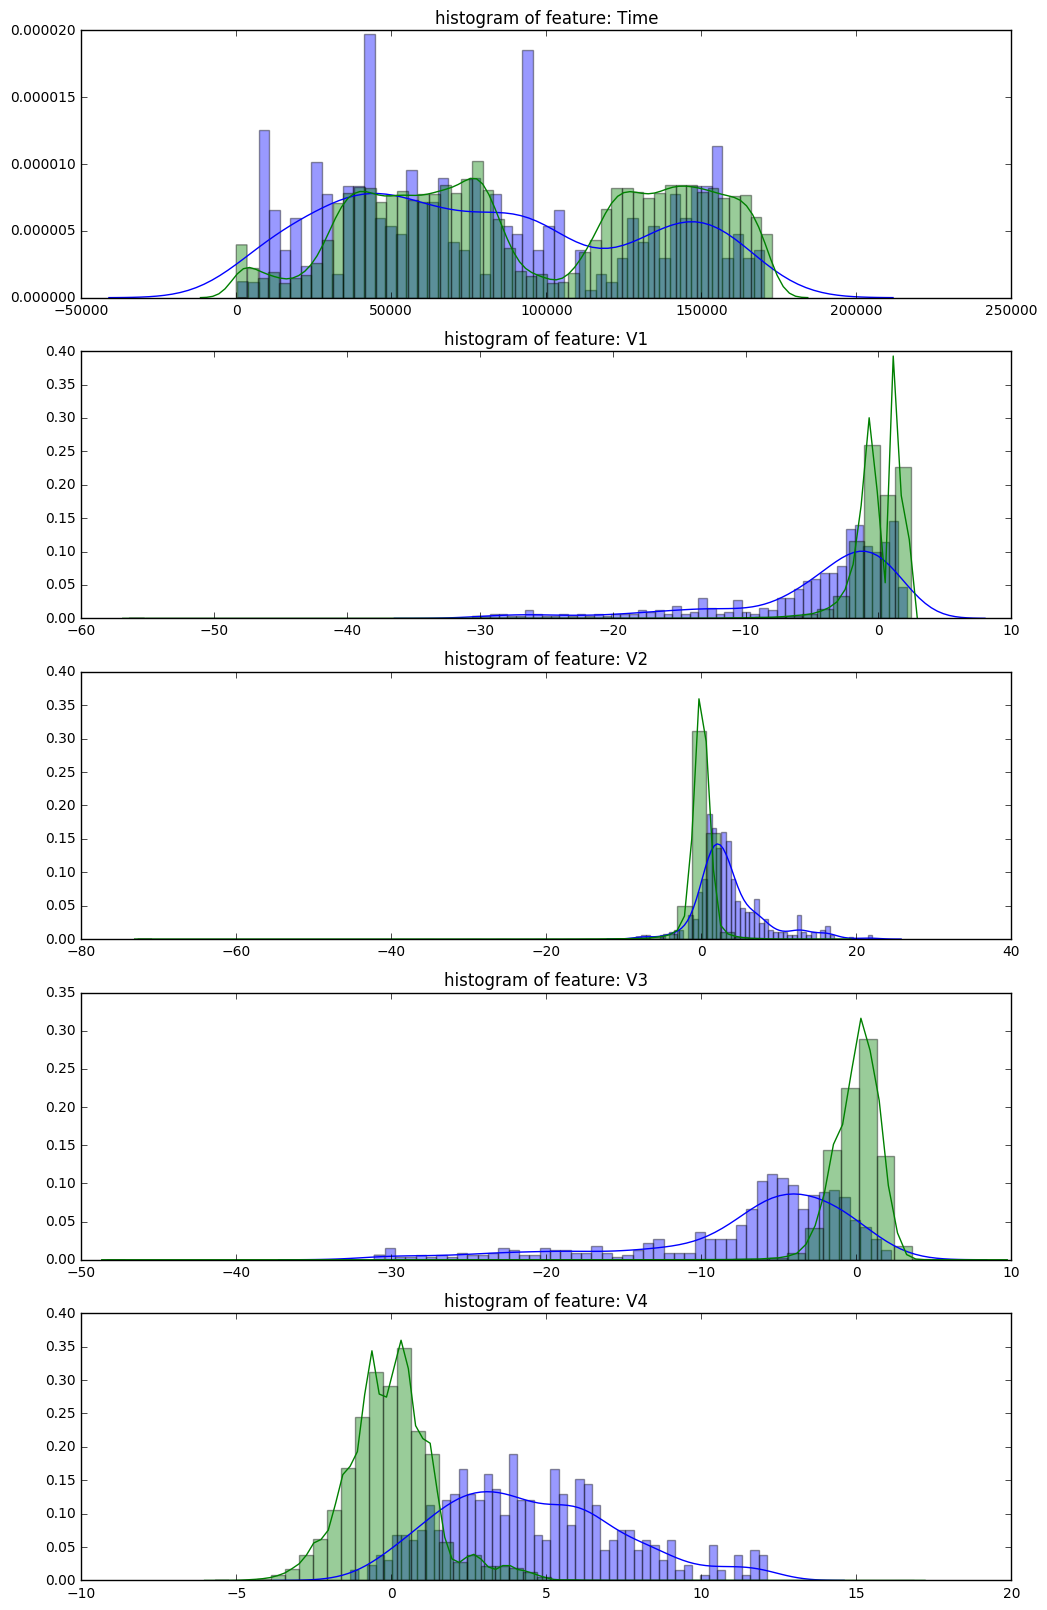

In [12]:
plt.figure(figsize=(12,5*4))
gs = gridspec.GridSpec(5, 1)
for i, cn in enumerate(df.columns[:5]):
    ax = plt.subplot(gs[i])
    sns.distplot(df[cn][df.Class == 1], bins=50)
    sns.distplot(df[cn][df.Class == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(cn))
plt.show()

## Train and test split on time series, using first 75% as training/val, and last 25% as test

In [13]:
TEST_RATIO = 0.25
df.sort_values('Time', inplace = True)
TRA_INDEX = int((1-TEST_RATIO) * df.shape[0])
train_x = df.iloc[:TRA_INDEX, 1:-2].values
train_y = df.iloc[:TRA_INDEX, -1].values

test_x = df.iloc[TRA_INDEX:, 1:-2].values
test_y = df.iloc[TRA_INDEX:, -1].values

In [14]:
print("Total train examples: {}, total fraud cases: {}, equal to {:.5f} of total cases. ".format(train_x.shape[0], np.sum(train_y), np.sum(train_y)/train_x.shape[0]))

Total train examples: 213605, total fraud cases: 398, equal to 0.00186 of total cases. 


In [15]:
print("Total test examples: {}, total fraud cases: {}, equal to {:.5f} of total cases. ".format(test_x.shape[0], np.sum(test_y), np.sum(test_y)/test_y.shape[0]))

Total test examples: 71202, total fraud cases: 94, equal to 0.00132 of total cases. 


## Feature Normalization - min max score (used for sigmoid activation)

In [16]:
'''cols_max = []
cols_min = []
for c in range(train_x.shape[1]):
    cols_max.append(train_x[:,c].max())
    cols_min.append(train_x[:,c].min())
    train_x[:, c] = (train_x[:, c] - cols_min[-1]) / (cols_max[-1] - cols_min[-1])
    test_x[:, c] =  (test_x[:, c] - cols_min[-1]) / (cols_max[-1] - cols_min[-1])'''

'cols_max = []\ncols_min = []\nfor c in range(train_x.shape[1]):\n    cols_max.append(train_x[:,c].max())\n    cols_min.append(train_x[:,c].min())\n    train_x[:, c] = (train_x[:, c] - cols_min[-1]) / (cols_max[-1] - cols_min[-1])\n    test_x[:, c] =  (test_x[:, c] - cols_min[-1]) / (cols_max[-1] - cols_min[-1])'

## Feature Normalization 2 - z score (for tanh activation)

In [17]:
cols_mean = []
cols_std = []
for c in range(train_x.shape[1]):
    cols_mean.append(train_x[:,c].mean())
    cols_std.append(train_x[:,c].std())
    train_x[:, c] = (train_x[:, c] - cols_mean[-1]) / cols_std[-1]
    test_x[:, c] =  (test_x[:, c] - cols_mean[-1]) / cols_std[-1]

## Modelling and results


## 1. Auto-encoder as unsupervised learning

### Parameters

In [18]:
# Parameters
learning_rate = 0.001
training_epochs = 10
batch_size = 256
display_step = 1

# Network Parameters
n_hidden_1 = 15 # 1st layer num features
#n_hidden_2 = 15 # 2nd layer num features
n_input = train_x.shape[1] # MNIST data input (img shape: 28*28)
data_dir = '.'

### Train and val the model - (1 hidden layer turned out to be enough)

In [20]:
X = tf.placeholder("float", [None, n_input])

weights = {
    'encoder_h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    #'encoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'decoder_h1': tf.Variable(tf.random_normal([n_hidden_1, n_input])),
    #'decoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_input])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    #'encoder_b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'decoder_b1': tf.Variable(tf.random_normal([n_input])),
    #'decoder_b2': tf.Variable(tf.random_normal([n_input])),
}


# Building the encoder
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.tanh(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    #layer_2 = tf.nn.tanh(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   #biases['encoder_b2']))
    return layer_1


# Building the decoder
def decoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.tanh(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    #layer_2 = tf.nn.tanh(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                  # biases['decoder_b2']))
    return layer_1

# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# Define batch mse
batch_mse = tf.reduce_mean(tf.pow(y_true - y_pred, 2), 1)

# Define loss and optimizer, minimize the squared error
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

# TRAIN StARTS
save_model = os.path.join(data_dir, 'temp_saved_model_1layer.ckpt')
saver = tf.train.Saver()

# Initializing the variables
init = tf.initialize_all_variables()

with tf.Session() as sess:
    now = datetime.now()
    sess.run(init)
    total_batch = int(train_x.shape[0]/batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        # Loop over all batches
        for i in range(total_batch):
            batch_idx = np.random.choice(train_x.shape[0], batch_size)
            batch_xs = train_x[batch_idx]
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs})
            
        # Display logs per epoch step
        if epoch % display_step == 0:
            train_batch_mse = sess.run(batch_mse, feed_dict={X: train_x})
            print("Epoch:", '%04d' % (epoch+1),
                  "cost=", "{:.9f}".format(c), 
                  "Train auc=", "{:.6f}".format(auc(train_y, train_batch_mse)), 
                  "Time elapsed=", "{}".format(datetime.now() - now))

    print("Optimization Finished!")
    
    save_path = saver.save(sess, save_model)
    print("Model saved in file: %s" % save_path)
    

Epoch: 0001 cost= 1.452319503 Train auc= 0.953621 Time elapsed= 0:00:02.547825
Epoch: 0002 cost= 0.971068978 Train auc= 0.955127 Time elapsed= 0:00:04.583242
Epoch: 0003 cost= 1.770709991 Train auc= 0.957192 Time elapsed= 0:00:06.560916
Epoch: 0004 cost= 1.381680131 Train auc= 0.955833 Time elapsed= 0:00:08.341001
Epoch: 0005 cost= 0.383263558 Train auc= 0.958124 Time elapsed= 0:00:11.610135
Epoch: 0006 cost= 0.422518194 Train auc= 0.958956 Time elapsed= 0:00:14.507968
Epoch: 0007 cost= 0.449446470 Train auc= 0.958780 Time elapsed= 0:00:16.687559
Epoch: 0008 cost= 0.483440548 Train auc= 0.958289 Time elapsed= 0:00:18.565139
Epoch: 0009 cost= 0.571881711 Train auc= 0.958448 Time elapsed= 0:00:20.345374
Epoch: 0010 cost= 0.385359615 Train auc= 0.958684 Time elapsed= 0:00:22.200936
Optimization Finished!
Model saved in file: ./temp_saved_model_1layer.ckpt


### Test model - on later 25% test data

In [22]:
save_model = os.path.join(data_dir, 'temp_saved_model_1layer.ckpt')
saver = tf.train.Saver()

# Initializing the variables
init = tf.initialize_all_variables()

with tf.Session() as sess:
    now = datetime.now()
    
    saver.restore(sess, save_model)
    
    test_batch_mse = sess.run(batch_mse, feed_dict={X: test_x})
    
    print("Test auc score: {:.6f}".format(auc(test_y, test_batch_mse)))
    

Test auc score: 0.946713


## Visualize the prediction

### 1. Display fraud score (mse) distribution for non-fraud cases

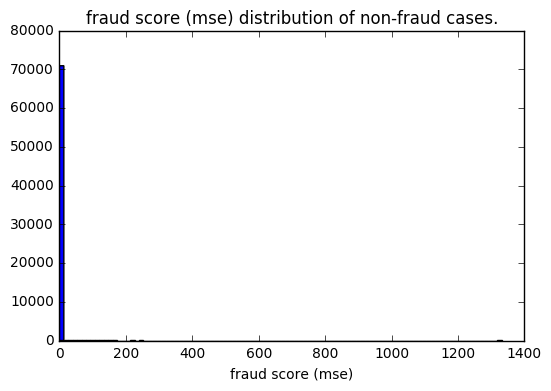

In [23]:
plt.hist(test_batch_mse[test_y == 0.0], bins = 100)
plt.title("fraud score (mse) distribution of non-fraud cases.")
plt.xlabel("fraud score (mse)")
plt.show()

### Zoom into (0, 20) range

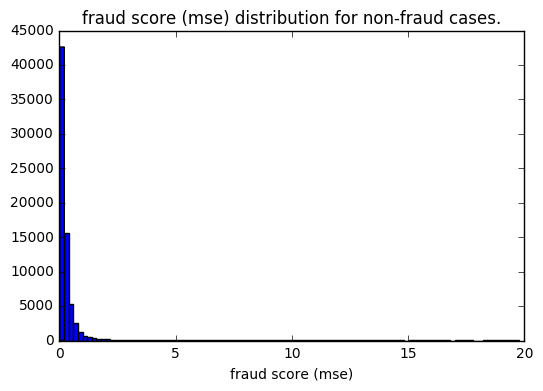

In [24]:
plt.hist(test_batch_mse[(test_y == 0.0) & (test_batch_mse < 20)], bins = 100)
plt.title("fraud score (mse) distribution for non-fraud cases.")
plt.xlabel("fraud score (mse)")
plt.show()

### 2. Display fraud score (mse) distribution for fraud cases

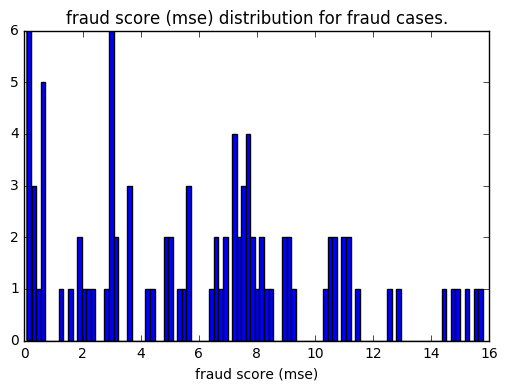

In [25]:
plt.hist(test_batch_mse[test_y == 1.0], bins = 100)
plt.title("fraud score (mse) distribution for fraud cases.")
plt.xlabel("fraud score (mse)")
plt.show()

In [26]:
THRE_TEST = 7
print("Let's, for example, use 7 as our detection threshold: \n\
Number of detected cases above treshold: {}, \n\
Number of pos cases only above threshold: {}, \n\
The percentage of accuracy above treshold (Precision): {:0.2f}%. \n\
Compared to the average percentage of fraud in test set: 0.132%".format( \
np.sum(test_batch_mse > THRE_TEST), \
np.sum(test_y[test_batch_mse > THRE_TEST]), \
np.sum(test_y[test_batch_mse > THRE_TEST]) / np.sum(test_batch_mse > THRE_TEST) * 100))
      

Let's, for example, use 7 as our detection threshold: 
Number of detected cases above treshold: 498, 
Number of pos cases only above threshold: 43, 
The percentage of accuracy above treshold (Precision): 8.63%. 
Compared to the average percentage of fraud in test set: 0.132%


### Observation: Our precision increased by a factor of 60 from 0.132% to 7.86%; However, the detection precision is still low (below 8%), but this is mainly due to the overall percentage of fraud cases is really too low. 

## 2. Build a binary classifier that predicts fraud, using the auto-encoder embedding layers as model inputs. 

### 1) Get auto-encoder embedding (the `encoder_op` tensor) for both train and test data

In [28]:
save_model = os.path.join(data_dir, 'temp_saved_model_1layer.ckpt')
saver = tf.train.Saver()

# Initializing the variables
init = tf.initialize_all_variables()

with tf.Session() as sess:
    now = datetime.now()
    saver.restore(sess, save_model)
    
    test_encoding = sess.run(encoder_op, feed_dict={X: test_x})
    train_encoding = sess.run(encoder_op, feed_dict={X: train_x})
    
    print("Dim for test_encoding and train_encoding are: \n", test_encoding.shape, '\n', train_encoding.shape)

Dim for test_encoding and train_encoding are: 
 (71202, 15) 
 (213605, 15)


### 2) Build the graph for FC layers (best hidden size based on validation is found to be 4)

In [29]:
#n_input = test_encoding.shape[1]
n_input = test_encoding.shape[1]

hidden_size = 4
output_size = 2

X = tf.placeholder(tf.float32, [None, n_input], name='input_x')
y_ = tf.placeholder(tf.int32, shape=[None, output_size], name='target_y')

weights = {
    'W1': tf.Variable(tf.truncated_normal([n_input, hidden_size])),
    'W2': tf.Variable(tf.truncated_normal([hidden_size, output_size])),
}
biases = {
    'b1': tf.Variable(tf.zeros([hidden_size])),
    'b2': tf.Variable(tf.zeros([output_size])),
}

hidden_layer =  tf.nn.relu(tf.add(tf.matmul(X, weights['W1']), biases['b1']))
pred_logits = tf.add(tf.matmul(hidden_layer, weights['W2']), biases['b2'])
pred_probs = tf.nn.softmax(pred_logits)

cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=pred_logits))

optimizer = tf.train.AdamOptimizer(2e-4).minimize(cross_entropy)


### 3) Prepare the data set. 
### Now we need to re-split the train into train/val, due to supervised training.
### We will therefore use 80% of out previous training data as our new training, and the remaining 20% as new validation. (train : val : test = (0.75x0.8) : (0.75x0.2) : (0.25x1.0)). 
### Finally we start to train our binary classifier

In [32]:
n_epochs = 80
batch_size = 256

# PREPARE DATA
VAL_PERC = 0.2
all_y_bin = np.zeros((df.shape[0], 2))
all_y_bin[range(df.shape[0]), df['Class'].values] = 1

train_enc_x = train_encoding[:int(train_encoding.shape[0] * (1-VAL_PERC))]
train_enc_y = all_y_bin[:int(train_encoding.shape[0] * (1-VAL_PERC))]

val_enc_x = train_encoding[int(train_encoding.shape[0] * (1-VAL_PERC)):]
val_enc_y = all_y_bin[int(train_encoding.shape[0] * (1-VAL_PERC)):train_encoding.shape[0]]

test_enc_y = all_y_bin[train_encoding.shape[0]:]
print("Num of data for train, val and test are: \n{}, \n{}, \n{}".format(train_enc_x.shape[0], val_enc_x.shape[0], \
                                                                        test_encoding.shape[0]))

# TRAIN STARTS
save_model = os.path.join(data_dir, 'temp_saved_model_FCLayers.ckpt')
saver = tf.train.Saver()

# Initializing the variables
init = tf.initialize_all_variables()

with tf.Session() as sess:
    now = datetime.now()
    sess.run(init)
    total_batch = int(train_enc_x.shape[0]/batch_size)
    # Training cycle
    for epoch in range(n_epochs):
        # Loop over all batches
        for i in range(total_batch):
            batch_idx = np.random.choice(train_enc_x.shape[0], batch_size)
            batch_xs = train_enc_x[batch_idx]
            batch_ys = train_enc_y[batch_idx]

            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cross_entropy], feed_dict={X: batch_xs, y_: batch_ys})
            
        # Display logs per epoch step
        if epoch % display_step == 0:
            val_probs = sess.run(pred_probs, feed_dict={X: val_enc_x})
            print("Epoch:", '%04d' % (epoch+1),
                  "cost=", "{:.9f}".format(c), 
                  "Val auc=", "{:.6f}".format(auc(val_enc_y[:, 1], val_probs[:, 1])), 
                  "Time elapsed=", "{}".format(datetime.now() - now))

    print("Optimization Finished!")
    
    save_path = saver.save(sess, save_model)
    print("Model saved in file: %s" % save_path)
    

Num of data for train, val and test are: 
170884, 
42721, 
71202
Epoch: 0001 cost= 1.298092842 Val auc= 0.508329 Time elapsed= 0:00:02.046094
Epoch: 0002 cost= 0.611705840 Val auc= 0.283895 Time elapsed= 0:00:02.918491
Epoch: 0003 cost= 0.235570237 Val auc= 0.227692 Time elapsed= 0:00:03.756400
Epoch: 0004 cost= 0.104837909 Val auc= 0.226404 Time elapsed= 0:00:04.556835
Epoch: 0005 cost= 0.074484222 Val auc= 0.244649 Time elapsed= 0:00:05.371235
Epoch: 0006 cost= 0.059484717 Val auc= 0.314229 Time elapsed= 0:00:06.646311
Epoch: 0007 cost= 0.045309812 Val auc= 0.439336 Time elapsed= 0:00:07.837302
Epoch: 0008 cost= 0.023352841 Val auc= 0.586274 Time elapsed= 0:00:08.696189
Epoch: 0009 cost= 0.015820362 Val auc= 0.738040 Time elapsed= 0:00:09.503623
Epoch: 0010 cost= 0.013903694 Val auc= 0.823923 Time elapsed= 0:00:10.265416
Epoch: 0011 cost= 0.015837952 Val auc= 0.856296 Time elapsed= 0:00:11.081238
Epoch: 0012 cost= 0.013442790 Val auc= 0.869478 Time elapsed= 0:00:11.904512
Epoch: 0013

### 4) Test the model on the same test data as before - improved on AUC slightly - 0.9669

In [33]:
save_model = os.path.join(data_dir, 'temp_saved_model_FCLayers.ckpt')
saver = tf.train.Saver()
# Initializing the variables
init = tf.initialize_all_variables()

with tf.Session() as sess:
    now = datetime.now()
    
    saver.restore(sess, save_model)
    
    test_probs = sess.run(pred_probs, feed_dict={X: test_encoding})
    
    print("\nTest auc score: {}".format(auc(test_enc_y[:, 1], test_probs[:, 1])))


Test auc score: 0.9516433797436085


## 3. (Optional) However, let's test a simple supervisied neural network (two layers FC) from scratch - without using auto-encoder

### 1) Build graph - 28 (input) -> 8 -> 4 -> 2

In [44]:
n_epochs = 200
batch_size = 256

#n_input = test_encoding.shape[1]
n_input = train_x.shape[1]

hidden1_size = 8
hidden2_size = 4
output_size = 2

X = tf.placeholder(tf.float32, [None, n_input], name='input_x')
y_ = tf.placeholder(tf.int32, shape=[None, output_size], name='target_y')

weights = {
    'W1': tf.Variable(tf.truncated_normal([n_input, hidden1_size])),
    'W2': tf.Variable(tf.truncated_normal([hidden1_size, hidden2_size])),
    'W3': tf.Variable(tf.truncated_normal([hidden2_size, output_size])),
}
biases = {
    'b1': tf.Variable(tf.zeros([hidden1_size])),
    'b2': tf.Variable(tf.zeros([hidden2_size])),
    'b3': tf.Variable(tf.zeros([output_size])),
}

hidden1_layer =  tf.nn.relu(tf.add(tf.matmul(X, weights['W1']), biases['b1']))
hidden2_layer =  tf.nn.relu(tf.add(tf.matmul(hidden1_layer, weights['W2']), biases['b2']))
pred_logits = tf.add(tf.matmul(hidden2_layer, weights['W3']), biases['b3'])
pred_probs = tf.nn.softmax(pred_logits)

cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=pred_logits))

optimizer = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)


### 2) Prepare the data set. Now we need to re-split the train into train/val. 
### Again, we will use 80% of out previous training data as our new training, and the remaining 20% as new validation. (train : val : test = (0.75x0.8) : (0.75x0.2) : (0.25x1.0)).


In [45]:
# PREPARE DATA
VAL_PERC = 0.2
all_y_bin = np.zeros((df.shape[0], 2))
all_y_bin[range(df.shape[0]), df['Class'].values] = 1

train_enc_x = train_x[:int(train_x.shape[0] * (1-VAL_PERC))]
train_enc_y = all_y_bin[:int(train_x.shape[0] * (1-VAL_PERC))]

val_enc_x = train_x[int(train_encoding.shape[0] *  (1-VAL_PERC)):]
val_enc_y = all_y_bin[int(train_encoding.shape[0] * (1-VAL_PERC)):train_x.shape[0]]

test_enc_y = all_y_bin[train_x.shape[0]:]

print("Num of data for train, val and test are: \n{}, \n{}, \n{}".format(train_enc_x.shape[0], val_enc_x.shape[0], \
                                                                        test_encoding.shape[0]))
# TRAIN STARTS
save_model = os.path.join(data_dir, 'temp_saved_model_FCNNets_raw.ckpt')
saver = tf.train.Saver()

# Initializing the variables
init = tf.initialize_all_variables()

with tf.Session() as sess:
    now = datetime.now()
    sess.run(init)
    total_batch = int(train_enc_x.shape[0]/batch_size)
    # Training cycle
    for epoch in range(n_epochs):
        # Loop over all batches
        for i in range(total_batch):
            batch_idx = np.random.choice(train_enc_x.shape[0], batch_size)
            batch_xs = train_enc_x[batch_idx]
            batch_ys = train_enc_y[batch_idx]
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cross_entropy], feed_dict={X: batch_xs, y_: batch_ys})
            
        # Display logs per epoch step
        if epoch % display_step == 0:
            val_probs = sess.run(pred_probs, feed_dict={X: val_enc_x})
            print("Epoch:", '%04d' % (epoch+1),
                  "cost=", "{:.9f}".format(c), 
                  "Val auc=", "{:.6f}".format(auc(val_enc_y[:, 1], val_probs[:, 1])), 
                  "Time elapsed=", "{}".format(datetime.now() - now))

    print("Optimization Finished!")
    
    save_path = saver.save(sess, save_model)
    print("Model saved in file: %s" % save_path)
    

Num of data for train, val and test are: 
170884, 
42721, 
71202
Epoch: 0001 cost= 0.040468249 Val auc= 0.325239 Time elapsed= 0:00:05.180817
Epoch: 0002 cost= 0.035306405 Val auc= 0.388354 Time elapsed= 0:00:05.851594
Epoch: 0003 cost= 0.035373054 Val auc= 0.467323 Time elapsed= 0:00:06.498285
Epoch: 0004 cost= 0.058311760 Val auc= 0.532444 Time elapsed= 0:00:07.163055
Epoch: 0005 cost= 0.019052731 Val auc= 0.593557 Time elapsed= 0:00:07.815824
Epoch: 0006 cost= 0.044786640 Val auc= 0.645813 Time elapsed= 0:00:08.532697
Epoch: 0007 cost= 0.018334387 Val auc= 0.701125 Time elapsed= 0:00:09.236605
Epoch: 0008 cost= 0.014931509 Val auc= 0.769009 Time elapsed= 0:00:09.936430
Epoch: 0009 cost= 0.011636144 Val auc= 0.810144 Time elapsed= 0:00:10.559088
Epoch: 0010 cost= 0.008489504 Val auc= 0.832298 Time elapsed= 0:00:11.160689
Epoch: 0011 cost= 0.006762304 Val auc= 0.843969 Time elapsed= 0:00:11.762322
Epoch: 0012 cost= 0.007114011 Val auc= 0.851879 Time elapsed= 0:00:12.370904
Epoch: 0013

### 3) Predict on test data

In [47]:
save_model = os.path.join(data_dir, 'temp_saved_model_FCNNets_raw.ckpt')
saver = tf.train.Saver()
# Initializing the variables
init = tf.initialize_all_variables()

with tf.Session() as sess:
    now = datetime.now()
    
    saver.restore(sess, save_model)
    
    test_probs = sess.run(pred_probs, feed_dict={X: test_x})
    
    print("Test auc score: {}".format(auc(test_enc_y[:, 1], test_probs[:, 1])))

INFO:tensorflow:Restoring parameters from C:\Users\weimin\Desktop\Fraud\temp_saved_model_FCNNets_raw.ckpt
Test auc score: 0.9480815965884679
